# prep airbnb listings data


### imports


In [78]:
from typing import Any
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import re
import geopandas as gpd
import shapely as shp

### load data


In [79]:
data = pd.read_csv("../local_data/relevant_listings.csv")

In [80]:
data.shape

(2511, 73)

### select required cols


In [81]:
required_cols = [
    "name",
    "latitude",
    "longitude",
    "price",
]
drop_cols = []
drop_ids = [
    29769890,  # listings price is incorrect in dataset
]
listings = data.drop(columns=drop_cols, errors="ignore").copy()
listings = listings.dropna(subset=required_cols)
listings = listings[~listings["id"].isin(drop_ids)]

## process data


In [82]:
def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert cols to appropriate data types.
    """
    # Make a copy to avoid modifying original
    df = df.copy()

    # Convert date cols to datetime
    date_cols = ["last_scraped", "host_since", "first_review", "last_review"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])

    # Convert boolean cols
    bool_cols = [
        "host_is_superhost",
        "host_has_profile_pic",
        "host_identity_verified",
        "has_availability",
        "instant_bookable",
    ]
    for col in bool_cols:
        df[col] = df[col].replace({"t": True, "f": False})

    # Convert price to numeric
    df["price"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)
    df["host_response_rate"] = (
        df["host_response_rate"].str.replace("%", "").str.replace(",", "").astype(float)
    )
    df["host_acceptance_rate"] = (
        df["host_acceptance_rate"]
        .str.replace("%", "")
        .str.replace(",", "")
        .astype(float)
    )

    # Convert amenities from string to list
    df["amenities"] = df["amenities"].apply(
        eval
    )  # Convert string representation to list

    return df


def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create time-based features.
    """
    current_date = pd.Timestamp.now()

    # Host experience duration (days)
    df["host_experience_days"] = (current_date - df["host_since"]).dt.days

    # Listing age (days)
    df["listing_age_days"] = (current_date - df["first_review"]).dt.days

    # Days since last review
    df["days_since_last_review"] = (current_date - df["last_review"]).dt.days

    return df


def create_location_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create location-based features.
    """
    # Zurich city center coordinates (approximate)
    ZURICH_CENTER = (47.3769, 8.5417)

    # Calculate distance to city center using Haversine formula
    def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        R = 6371  # Earth's radius in km

        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        return R * c

    df["distance_to_center_km"] = df.apply(
        lambda row: haversine_distance(
            row["latitude"], row["longitude"], ZURICH_CENTER[0], ZURICH_CENTER[1]
        ),
        axis=1,
    )

    return df


def create_price_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create price-related features.
    """
    # Price per person
    df["price_per_person"] = df["price"] / df["accommodates"]

    return df


def create_amenity_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create amenity-based features.
    """
    # Amenity count
    df["amenity_count"] = df["amenities"].str.len()

    # Get top amenities
    all_amenities = [item for sublist in df["amenities"] for item in sublist]
    top_amenities = pd.Series(all_amenities).value_counts().head(20).index

    # Create binary cols for top amenities
    for amenity in top_amenities:
        df[f'has_{amenity.lower().replace(" ", "_")}'] = df["amenities"].apply(
            lambda x: amenity in x if isinstance(x, list) else False
        )

    return df


def create_categorical_dummies(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create dummy variables for categorical columns.

    Args:
        df: DataFrame containing Airbnb listings

    Returns:
        DataFrame with added dummy columns
    """
    # Make a copy to avoid modifying original
    df = df.copy()

    # Columns to create dummies for
    categorical_cols = [
        "neighbourhood_group_cleansed",
        "neighbourhood_cleansed",
        "room_type",
    ]

    # Create dummies for each column
    for col in categorical_cols:
        if col in df.columns:
            # Create dummy columns with prefix
            dummy_cols = pd.get_dummies(df[col], prefix=f"{col}_", dtype=int)

            # Add dummy columns to dataframe
            df = pd.concat([df, dummy_cols], axis=1)

            # Drop original column
            df = df.drop(columns=[col])

    return df


def create_bathroom_features(df: pd.DataFrame) -> pd.DataFrame:
    df["bathrooms"] = df["bathrooms_text"].str.extract("(\d+\.?\d*)").astype(float)
    df.loc[
        df["bathrooms_text"].str.contains("half", flags=re.IGNORECASE, na=False)
        == True,
        "bathrooms",
    ] = 0.5
    df.rename(columns={"bathrooms_text": "bathrooms_shared"}, inplace=True)
    df["bathrooms_shared"] = np.where(
        df["bathrooms_shared"].str.contains("shared"), True, False
    )

    return df


def process_listings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process listings dataframe and create all features.
    """
    print("Converting data types...")
    df = convert_data_types(df)

    print("Creating time features...")
    df = create_time_features(df)

    print("Creating location features...")
    df = create_location_features(df)

    print("Creating price features...")
    df = create_price_features(df)

    print("Creating amenity features...")
    df = create_amenity_features(df)

    print("Creating bathroom features...")
    df = create_bathroom_features(df)

    print("Creating categorical dummies...")
    df = create_categorical_dummies(df)

    return df

### apply processing


In [83]:
listings_processed = process_listings(listings)

# Display new features
new_features = set(listings_processed.columns) - set(listings.columns)
print("\nnew features:")
for feature in sorted(new_features):
    print(f"- {feature}")

Converting data types...
Creating time features...
Creating location features...
Creating price features...
Creating amenity features...
Creating bathroom features...
Creating categorical dummies...

new features:
- amenity_count
- bathrooms_shared
- days_since_last_review
- distance_to_center_km
- has_bed_linens
- has_cooking_basics
- has_dedicated_workspace
- has_dishes_and_silverware
- has_dishwasher
- has_essentials
- has_hair_dryer
- has_hangers
- has_heating
- has_hot_water
- has_hot_water_kettle
- has_iron
- has_kitchen
- has_long_term_stays_allowed
- has_oven
- has_refrigerator
- has_self_check-in
- has_shampoo
- has_washer
- has_wifi
- host_experience_days
- listing_age_days
- neighbourhood_cleansed__Affoltern
- neighbourhood_cleansed__Albisrieden
- neighbourhood_cleansed__Alt-Wiedikon
- neighbourhood_cleansed__Altstetten
- neighbourhood_cleansed__City
- neighbourhood_cleansed__Enge
- neighbourhood_cleansed__Escher Wyss
- neighbourhood_cleansed__Fluntern
- neighbourhood_cleans

/var/folders/yl/5lpm18md5573lmw3xhd49s_m0000gn/T/ipykernel_3401/378933368.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({"t": True, "f": False})


## listings overview


In [84]:
def analyse_numerical_features(df: pd.DataFrame) -> None:
    """
    analyse numerical features with distributions using multiple 3x3 subplots.

    Args:
        df: DataFrame containing Airbnb listings
    """
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    plots_per_figure = 9
    n_figures = (len(numerical_cols) + plots_per_figure - 1) // plots_per_figure

    for fig_num in range(n_figures):
        start_idx = fig_num * plots_per_figure
        end_idx = min(start_idx + plots_per_figure, len(numerical_cols))
        current_cols = numerical_cols[start_idx:end_idx]

        fig, axes = plt.subplots(3, 3, figsize=(9, 9))
        fig.suptitle(
            f"Distribution of Numerical Features (Set {fig_num + 1})",
            fontsize=8,
            y=1.02,
        )

        axes_flat = axes.flatten()

        for i, col in enumerate(current_cols):
            ax = axes_flat[i]

            # Get non-null data and sample if necessary
            non_null_data = df[col].dropna()

            if len(non_null_data) == 0:
                ax.text(
                    0.5, 0.5, f"No data available\nfor {col}", ha="center", va="center"
                )
                ax.set_title(f"{col} Distribution")
                continue

            # Create distribution plot with limited bins
            sns.histplot(data=non_null_data, kde=True, ax=ax, bins=30)

            ax.set_title(f"{col} Distribution")
            ax.tick_params(axis="x", rotation=45)

            try:
                mean_val = non_null_data.mean()
                median_val = non_null_data.median()

                if pd.notnull(mean_val) and pd.notnull(median_val):
                    ax.axvline(
                        mean_val,
                        color="red",
                        linestyle="--",
                        alpha=0.5,
                        label=f"Mean: {mean_val:.2f}",
                    )
                    ax.axvline(
                        median_val,
                        color="green",
                        linestyle="--",
                        alpha=0.5,
                        label=f"Median: {median_val:.2f}",
                    )
                    ax.legend(fontsize="small")
            except Exception as e:
                print(f"Warning: Could not calculate statistics for {col}: {e!s}")

        for j in range(len(current_cols), 9):
            fig.delaxes(axes_flat[j])

        plt.tight_layout()
        plt.show()

    # Correlation matrix
    correlation_matrix = df[numerical_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1
    )
    plt.title("Correlation Matrix of Numerical Features")
    plt.tight_layout()
    plt.show()

    # # Price distribution by neighbourhood (top 10)
    # plt.figure(figsize=(12, 6))
    # sns.boxplot(
    #     data=df,
    #     x="neighbourhood_cleansed",
    #     y="price",
    #     order=df.groupby("neighbourhood_cleansed")["price"].median().nlargest(10).index,
    # )
    # plt.xticks(rotation=45)
    # plt.title("Price Distribution by Top 10 Neighbourhoods")
    # plt.tight_layout()
    # plt.show()


def analyse_categorical_features(df: pd.DataFrame) -> None:
    """
    analyse categorical features with visualizations.

    Args:
        df: DataFrame containing Airbnb listings
    """
    categorical_cols = df.select_dtypes(include=["object"]).columns

    # # Room type distribution
    # plt.figure(figsize=(10, 6))
    # sns.countplot(data=df, x="room_type")
    # plt.title("Room Type Distribution")
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    # # Average price by room type
    # plt.figure(figsize=(10, 6))
    # df.groupby("room_type")["price"].mean().plot(kind="bar")
    # plt.title("Average Price by Room Type")
    # plt.ylabel("Average Price ($)")
    # plt.tight_layout()
    # plt.show()

    # Amenities analysis (top 20)
    amenities_list = df["amenities"]
    all_amenities = [item for sublist in amenities_list for item in sublist]
    amenities_freq = pd.Series(all_amenities).value_counts()

    plt.figure(figsize=(12, 6))
    amenities_freq.head(20).plot(kind="bar")
    plt.title("Top 20 Most Common Amenities")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def detect_outliers(df: pd.DataFrame) -> dict[str, Any]:
    """
    Detect outliers in numerical cols using multiple methods.

    Args:
        df: DataFrame containing Airbnb listings

    Returns:
        Dictionary containing outlier information
    """
    numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
    outlier_info = {}

    for col in numerical_cols:
        # Skip cols with all missing vals
        if df[col].isna().all():
            continue

        # IQR method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3.0 * IQR
        upper_bound = Q3 + 3.0 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        # Z-score method
        non_null_data = df[col].dropna()
        if len(non_null_data) > 0:  # Only calculate if we have non-null vals
            z_scores = np.abs(stats.zscore(non_null_data))
            z_score_mask = z_scores > 3
            z_score_outliers = non_null_data[z_score_mask]
        else:
            z_score_outliers = pd.Series([])

        outlier_info[col] = {
            "iqr_outliers_count": len(iqr_outliers),
            "z_score_outliers_count": len(z_score_outliers),
            "iqr_bounds": (lower_bound, upper_bound),
        }

    return outlier_info


def analyse_geographical_distribution(df: pd.DataFrame) -> None:
    """
    analyse geographical distribution of listings.

    Args:
        df: DataFrame containing Airbnb listings
    """
    plt.figure(figsize=(12, 8))
    plt.scatter(
        df["longitude"],
        df["latitude"],
        c=df["price"],
        cmap="viridis",
        alpha=0.6,
        vmin=0,
        vmax=df["price"].quantile(0.99),
    )
    plt.colorbar(label="Price ($)")
    plt.title("Geographical Distribution of Listings by Price")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()


def analyse_data_quality(
    df: pd.DataFrame, outlier_info: dict[str, Any]
) -> dict[str, list[str]]:
    """
    Suggest data cleaning steps based on comprehensive analysis.

    Args:
        df: DataFrame containing Airbnb listings
        outlier_info: Dictionary containing outlier information

    Returns:
        Dictionary of cleaning data_quality organized by category
    """
    data_quality = {"1. missing vals": [], "2. Outliers": []}

    # 1. missing vals Analysis
    missing_percentages = df.isnull().mean() * 100
    high_missing = df.columns[missing_percentages > 50].tolist()
    moderate_missing = df.columns[
        (missing_percentages > 20) & (missing_percentages <= 50)
    ].tolist()
    low_missing = df.columns[
        (missing_percentages > 0) & (missing_percentages <= 20)
    ].tolist()

    if high_missing:
        data_quality["1. missing vals"].append(
            f"cols with >50% missing vals:\n   {', '.join(high_missing)}"
        )
    if moderate_missing:
        data_quality["1. missing vals"].append(
            f"cols with 20-50% missing vals:\n   {', '.join(moderate_missing)}"
        )
    if low_missing:
        data_quality["1. missing vals"].append(
            f"cols with <20% missing vals:\n   {', '.join(low_missing)}"
        )

    # 2. Outliers Analysis
    for col, info in outlier_info.items():
        if info["iqr_outliers_count"] > 0:
            data_quality["2. Outliers"].append(
                f"{col}: {info['iqr_outliers_count']} outliers (3x IQR method)"
            )

    return data_quality

### run listings overview


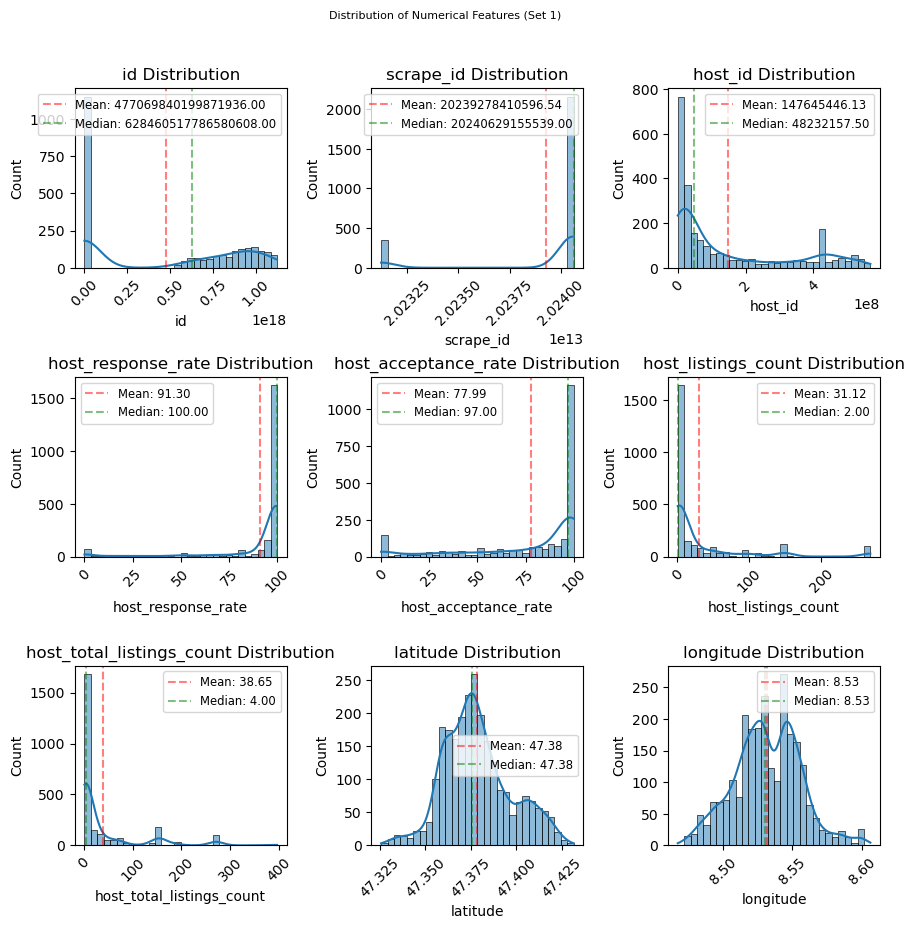

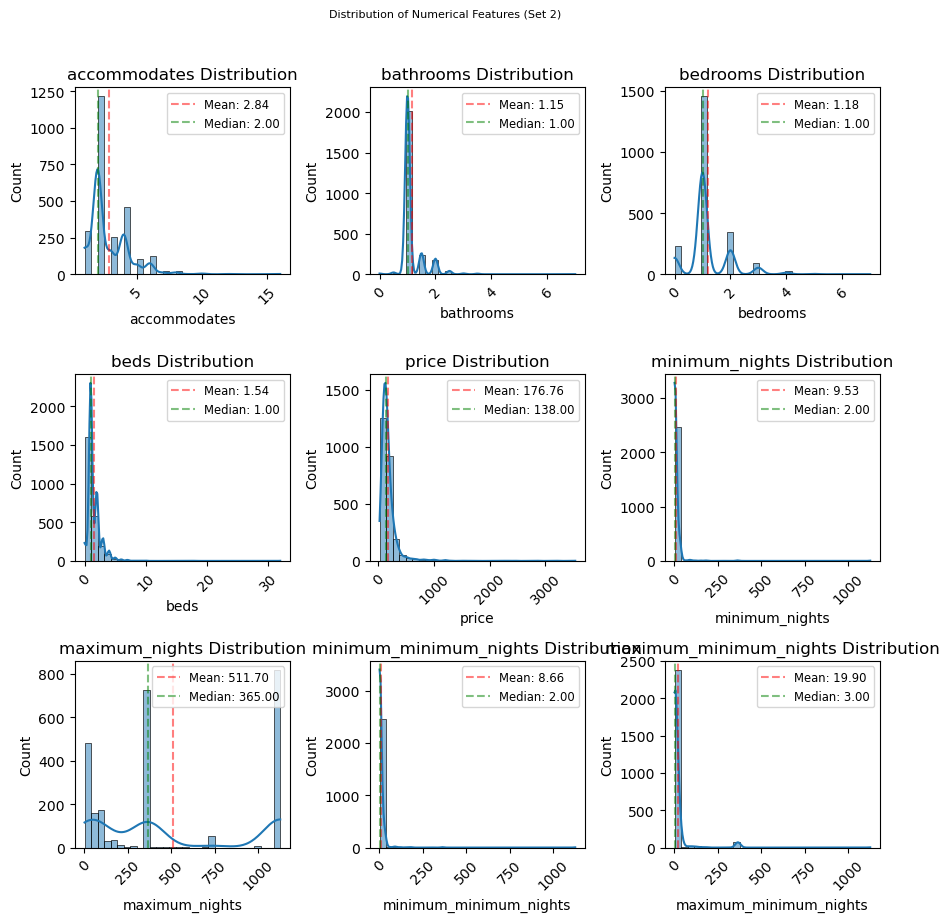

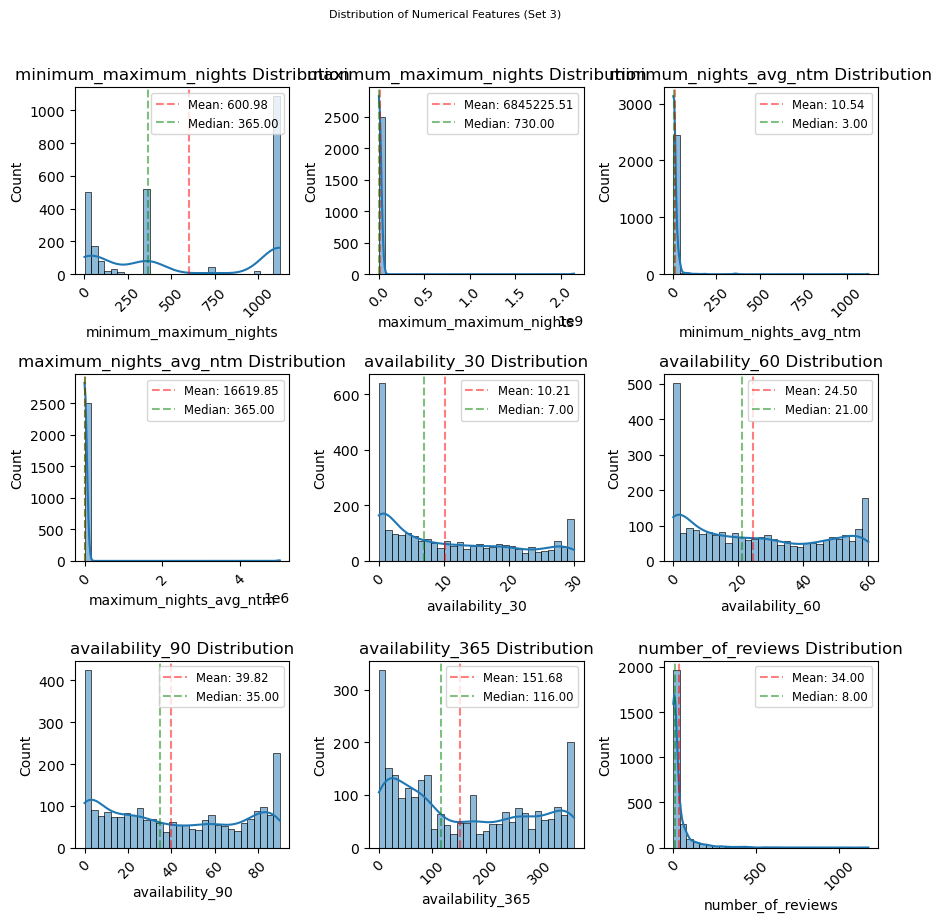

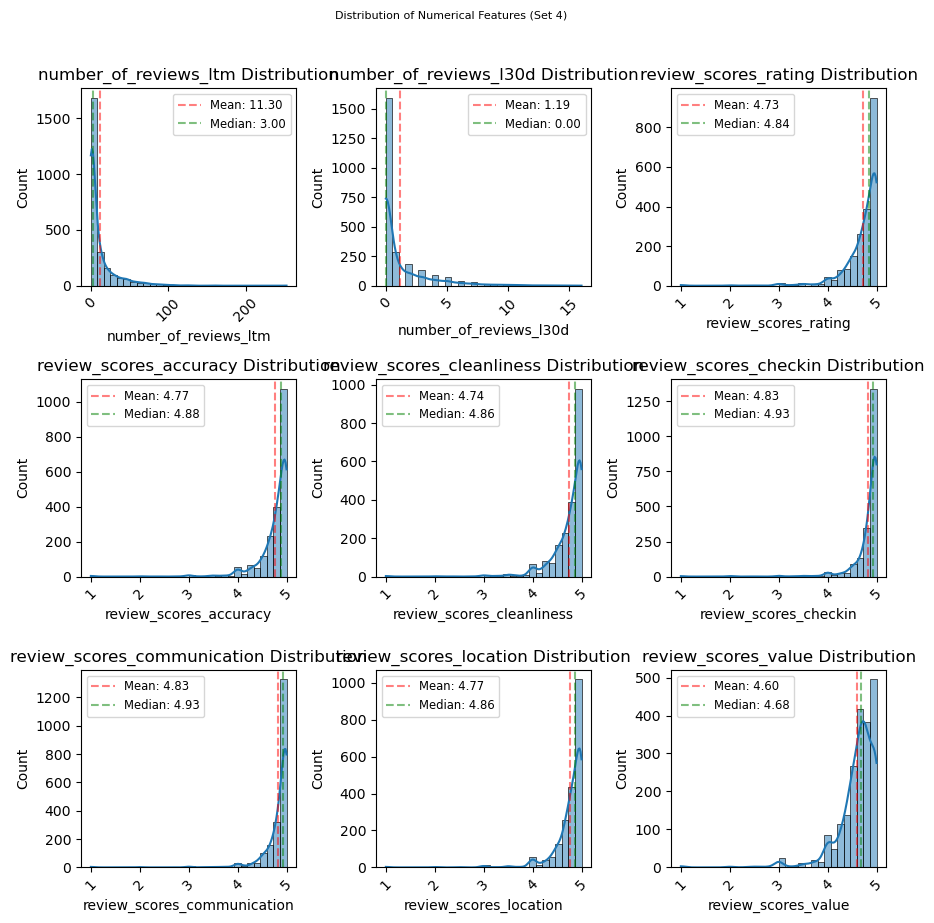

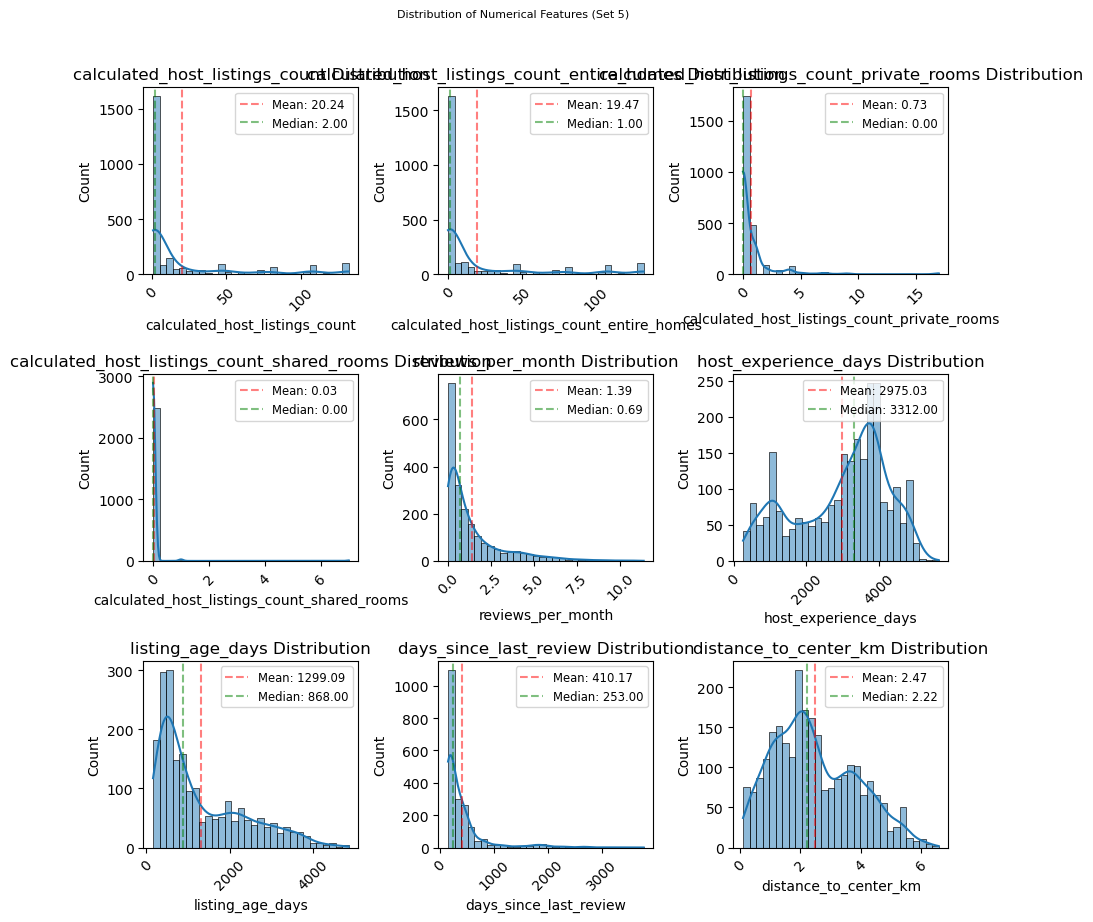

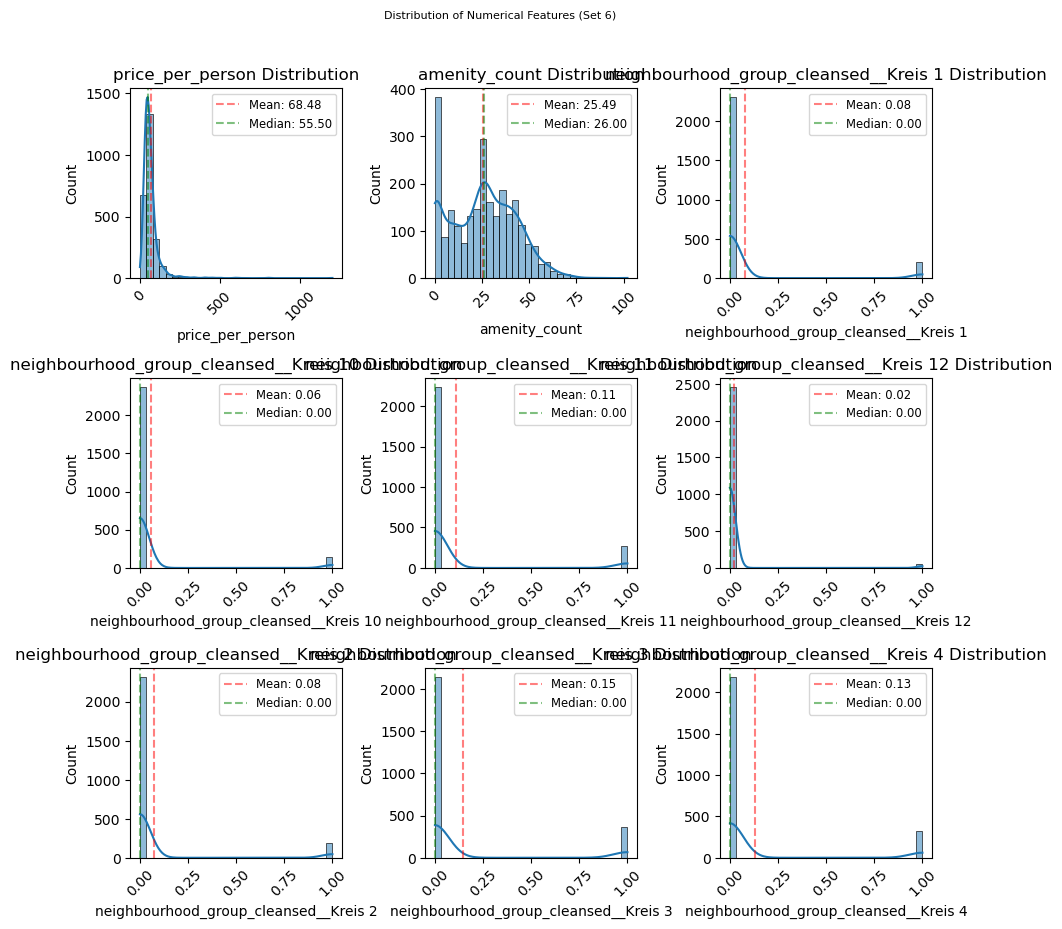

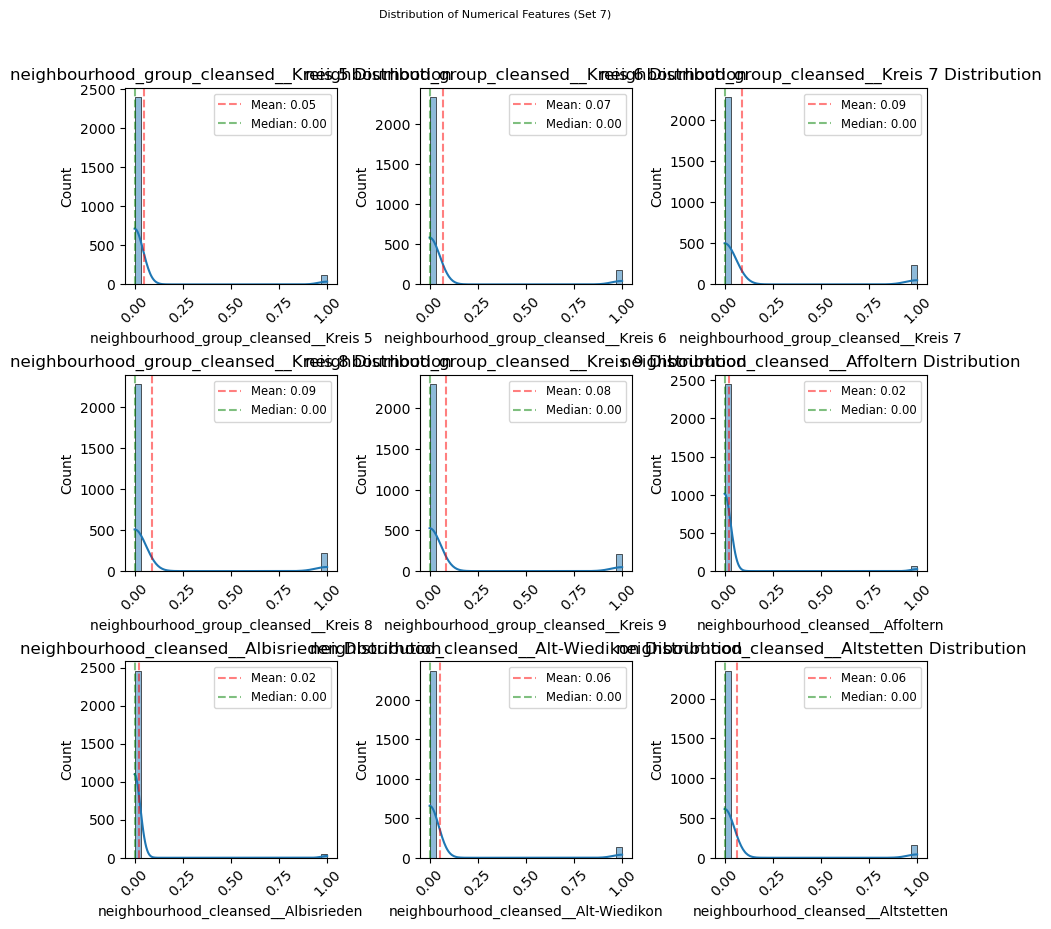

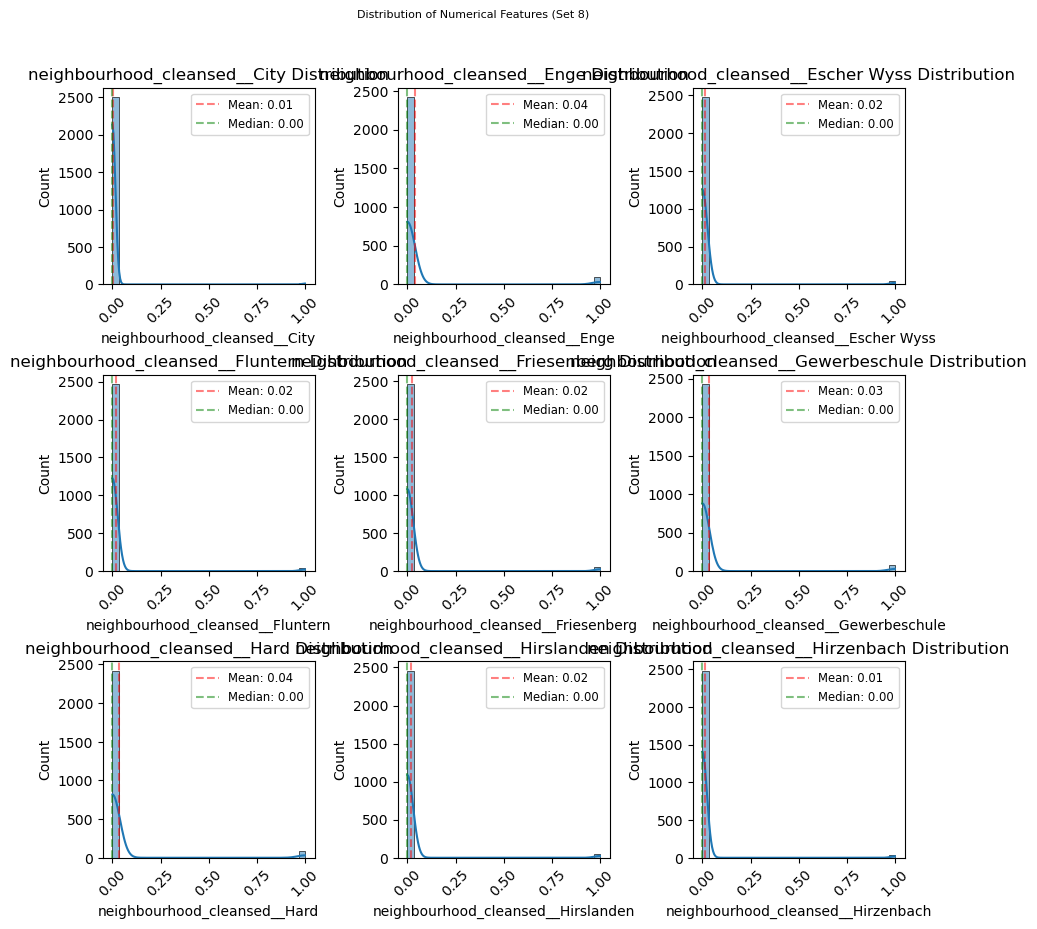

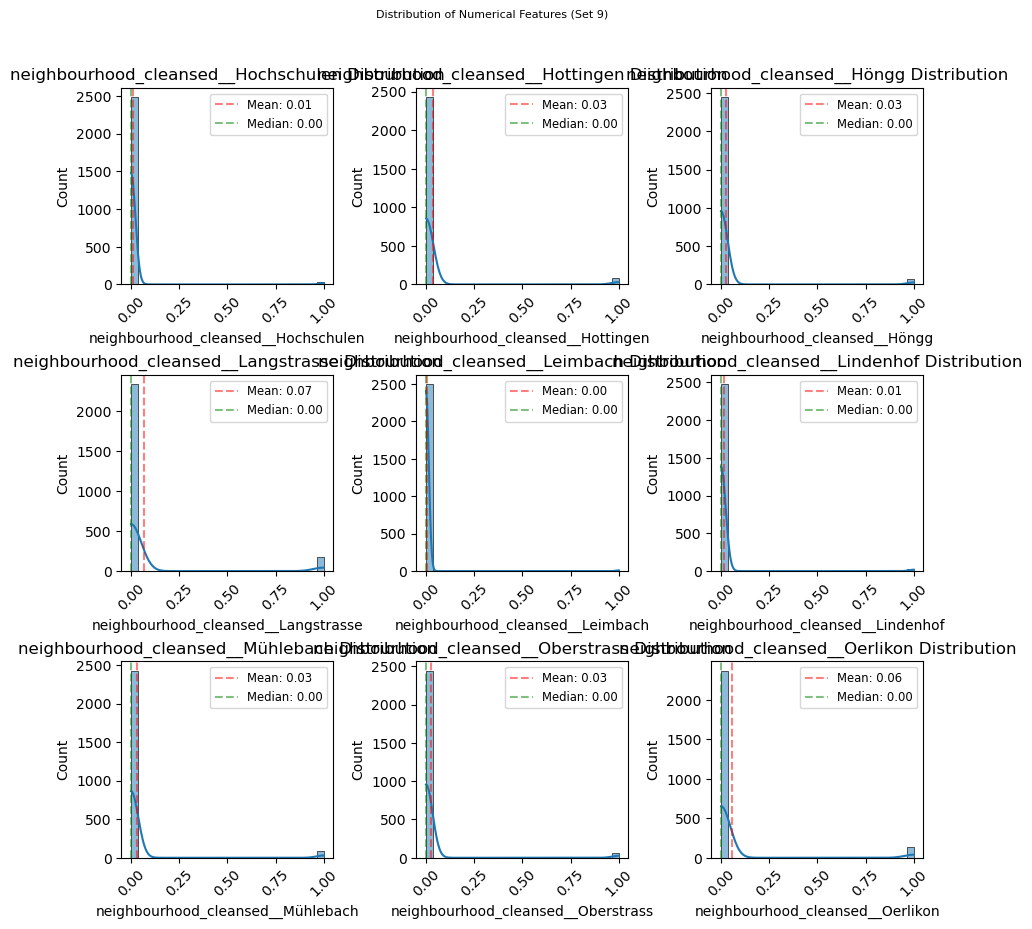

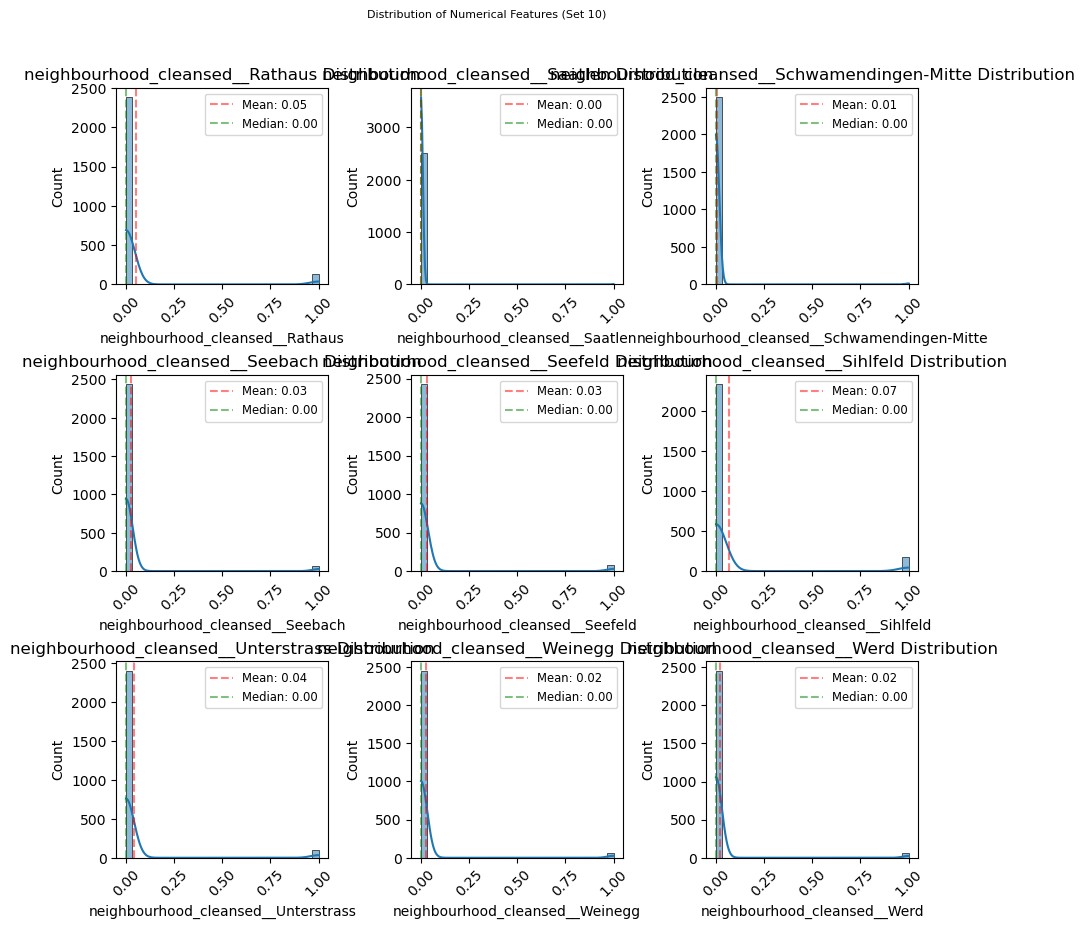

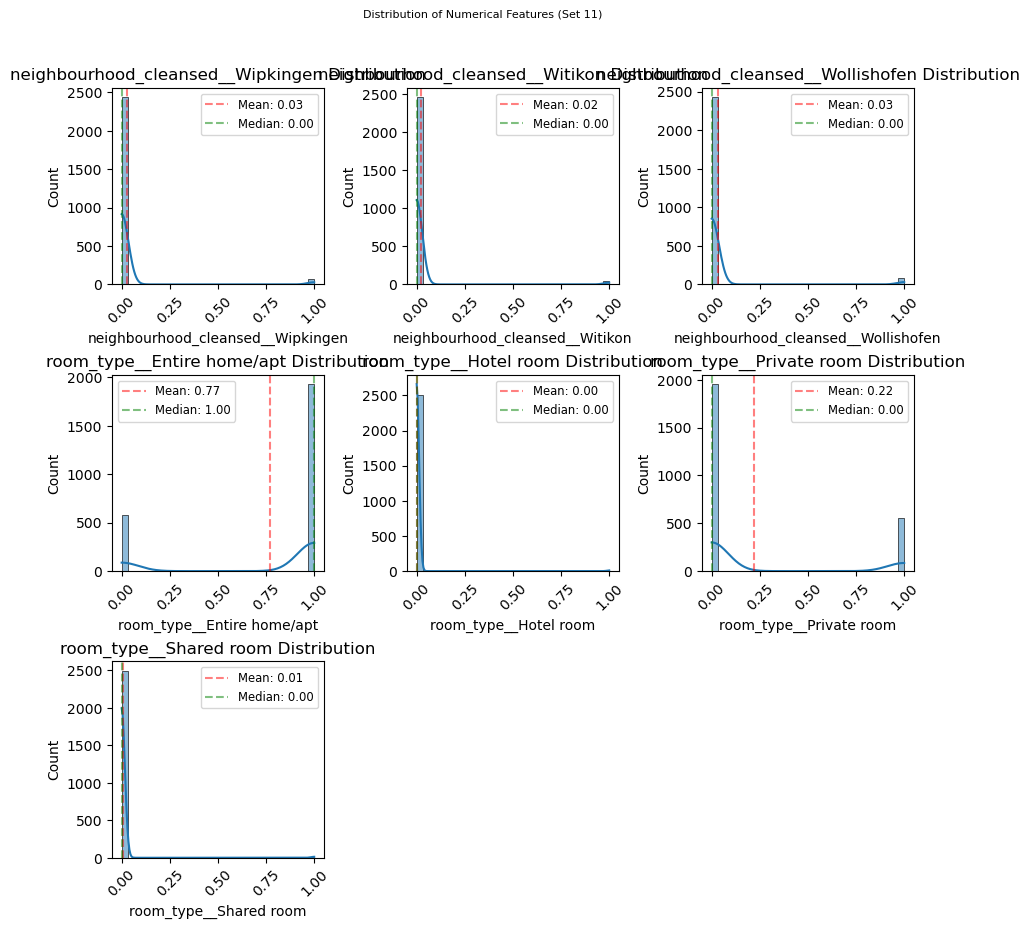

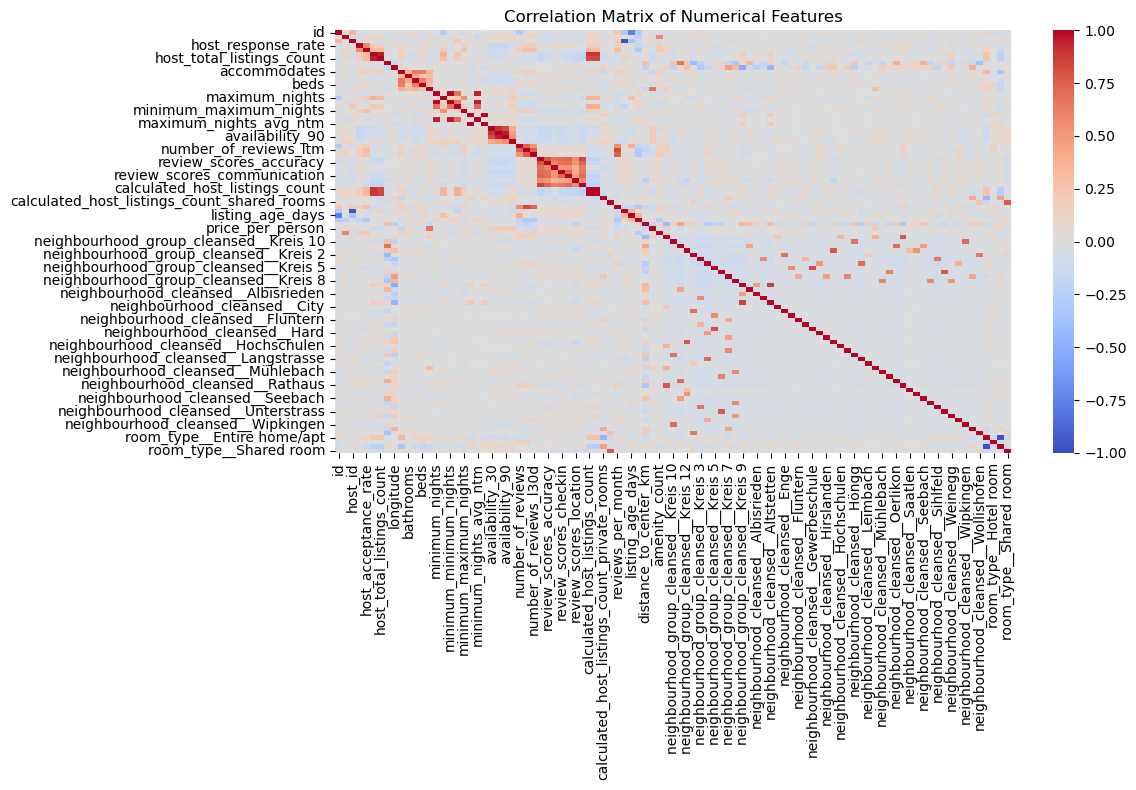

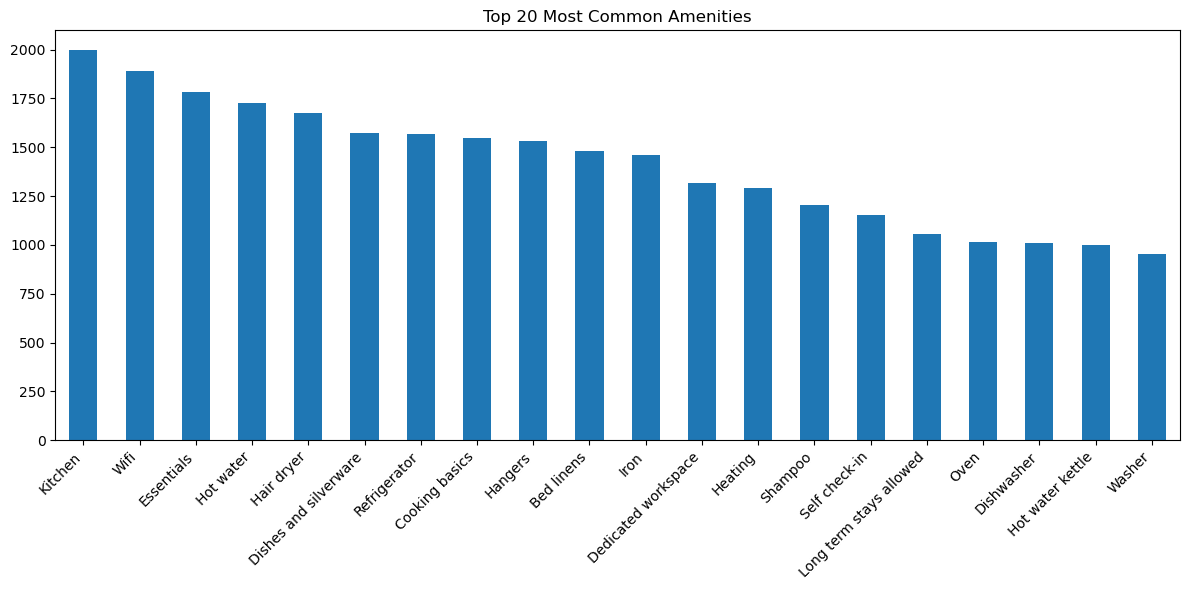

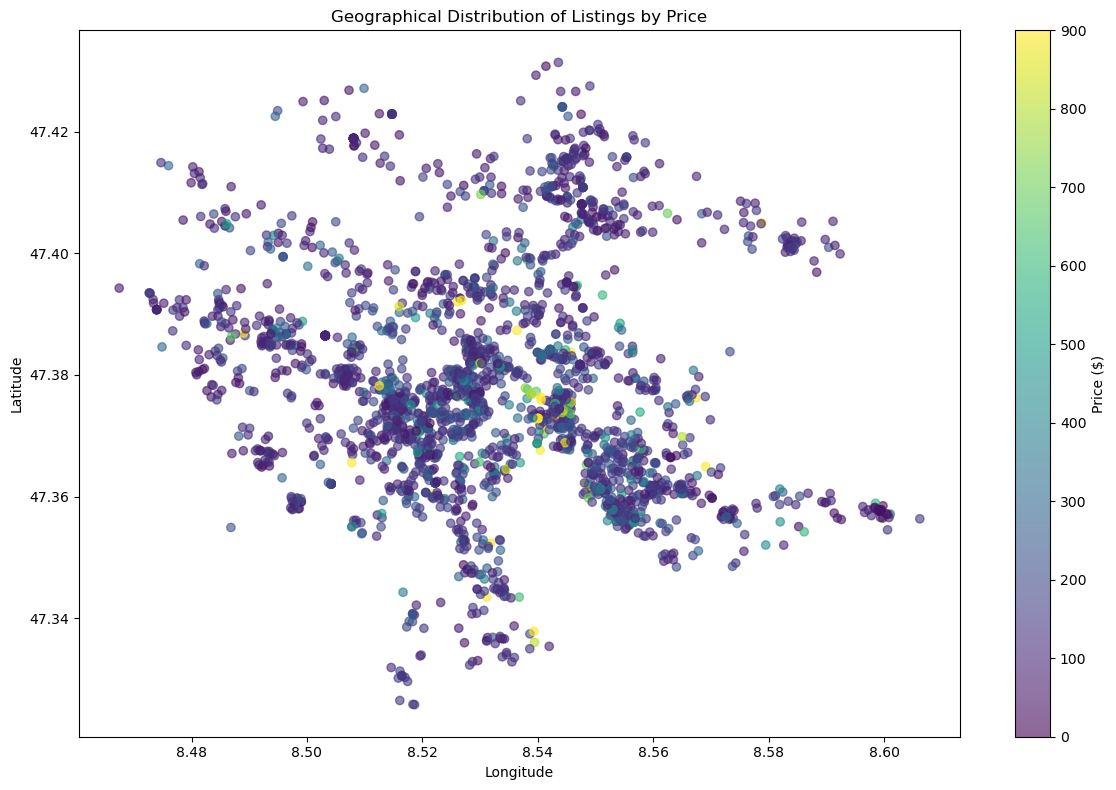

\data_quality comments:

1. missing vals
    cols with >50% missing vals:
   neighborhood_overview, host_neighbourhood, neighbourhood
    cols with 20-50% missing vals:
   host_about
    cols with <20% missing vals:
   description, host_location, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, bathrooms, bedrooms, beds, has_availability, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, reviews_per_month, listing_age_days, days_since_last_review

2. Outliers
    scrape_id: 351 outliers (3x IQR method)
    host_response_rate: 315 outliers (3x IQR method)
    host_listings_count: 270 outliers (3x IQR method)
    host_total_listings_count: 361 outliers (3x IQR method)
    accommodates: 8 outliers (3x IQR method)
    bathrooms: 493 outliers (3x IQR method)
    bedrooms: 698 outliers (3x IQR method)
    beds: 27 o

In [85]:
analyse_numerical_features(listings_processed)
analyse_categorical_features(listings_processed)
analyse_geographical_distribution(listings_processed)

outlier_info = detect_outliers(listings_processed)
data_quality = analyse_data_quality(listings_processed, outlier_info)

print(r"\data_quality comments:")
print("=========================================")
for category, items in data_quality.items():
    print(f"\n{category}")
    if items:  # Only print items if they exist
        for item in items:
            print(f"    {item}")

In [86]:
listings_processed.filter(
    listings_processed.select_dtypes(include=["object"]).columns
).head(2)

,listing_url,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_location,host_about,...,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,neighbourhood,property_type,amenities,has_availability,calendar_last_scraped
0,https://www.airbnb.com/rooms/697647035301296368,city scrape,Rental unit in Zürich · 1 bedroom · 1 bed · 1 ...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,https://www.airbnb.com/users/show/468683329,Christian,NaN,NaN,...,False,https://a0.muscache.com/im/pictures/user/30afd...,https://a0.muscache.com/im/pictures/user/30afd...,NaN,"['email', 'phone']",NaN,Private room in rental unit,[],True,2023-12-27
1,https://www.airbnb.com/rooms/693981461305609733,city scrape,Rental unit in Zürich · ★4.58 · 1 bedroom · 1 ...,NaN,The apartment is located in a calm area close ...,https://a0.muscache.com/pictures/a4930c5d-ab1c...,https://www.airbnb.com/users/show/123896618,Sharedlock,"Zürich, Switzerland","Hello, we are Sharedlock!\nSharedlock offers f...",...,False,https://a0.muscache.com/im/pictures/user/User-...,https://a0.muscache.com/im/pictures/user/User-...,NaN,"['email', 'phone']","Zürich, Switzerland",Entire rental unit,[],True,2023-12-27


In [87]:
drop_cols = [
    "neighborhood_overview",
    "host_neighbourhood",
    "host_neighbourhood",
    "neighbourhood",
    "listing_url",
    "source",
    "picture_url",
    "host_url",
    "host_about",
    "host_name",
    "host_location",
    "calendar_last_scraped",
    "last_scraped",
    "name",
    "source",
    "host_verifications",
    "host_thumbnail_url",
    "host_picture_url",
]

In [88]:
listings_processed = listings_processed.filter(
    [col for col in listings_processed.columns if col not in drop_cols]
)

## other datasets


In [89]:
tourism_data = pd.read_csv("../local_data/tourism.csv").dropna()
noise_data = pd.read_csv("../local_data/noise_data_cleaned.csv").dropna()
city_shape = gpd.read_file("../local_data/convex_hull_polygon.geojson")

In [90]:
def filter_tourism_data(tourism_data: pd.DataFrame,
                        city_shape: gpd.GeoDataFrame,
                        distance_to_city_km: float = 1.0
                        )-> pd.DataFrame:
    """
    Filter tourism data to only include rows within the city shape or within 1km of it.

    Args:
        tourism_data: DataFrame containing tourism data
        city_shape: GeoDataFrame containing city shape
        distance_to_city_km: Distance in km to consider as near the city

    Returns:
        Filtered tourism data
    """
    # Convert to GeoDataFrame
    near_tourism_data = gpd.GeoDataFrame(
        tourism_data,
        geometry=gpd.points_from_xy(tourism_data.longitude, tourism_data.latitude),
    )
    # Ensure CRS matches
    near_tourism_data = near_tourism_data.set_crs(city_shape.crs, allow_override=True)

    # Re-project to a projected CRS for accurate buffering
    city_shape_projected = city_shape.to_crs(epsg=3395)  # Use a suitable projected CRS
    city_shape_buffered = city_shape_projected.buffer(1000)  # 1km buffer

    # Re-project back to the original CRS
    city_shape_buffered = city_shape_buffered.to_crs(city_shape.crs)

    # Filter rows within the city shape or within 1km of it
    near_tourism_data = near_tourism_data[
        near_tourism_data.within(city_shape.union_all()) | near_tourism_data.within(city_shape_buffered.union_all())
    ]

    near_tourism_data = pd.DataFrame(near_tourism_data.drop(columns="geometry"))

    return near_tourism_data

near_tourism_data = filter_tourism_data(tourism_data, city_shape, distance_to_city_km=1.0)


In [91]:
near_tourism_data

,identifier,type,name,latitude,longitude,price
0,88375,BarOrPub,2. Akt Restaurant & Bar,47.369830,8.533639,"{'de': None, 'en': None, 'fr': None, 'it': None}"
1,88366,BarOrPub,4. Akt Restaurant & Bar,47.389523,8.521725,"{'de': None, 'en': None, 'fr': None, 'it': None}"
3,326061,BarOrPub,Acid,47.377111,8.526034,"{'de': None, 'en': None, 'fr': None, 'it': None}"
4,168166,BarOrPub,Aelpli Bar,47.371387,8.543551,"{'de': None, 'en': None, 'fr': None, 'it': None}"
5,86653,BarOrPub,Akt Niederdorf,47.375494,8.544079,"{'de': None, 'en': None, 'fr': None, 'it': None}"
...,...,...,...,...,...,...
959,1614,TouristAttraction,Waid Vantage Point,47.399613,8.514413,"{'de': None, 'en': None, 'fr': None, 'it': None}"
963,231310,TouristAttraction,"Zurich University of the Arts (ZHdK), Toni Campus",47.390507,8.511729,"{'de': None, 'en': None, 'fr': None, 'it': None}"
964,1740,TouristAttraction,Zurich-West – From Industrial Quarter to Trend...,47.388599,8.518129,"{'de': None, 'en': None, 'fr': None, 'it': None}"
971,2987,Zoo,Zurich Aviary and Bird Sanctuary,47.362298,8.535663,"{'de': '<p>Eintritt frei</p>\r\n', 'en': '<p>F..."


## distance features


In [92]:
def calculate_noise_features(
    listings: pd.DataFrame,
    noise_data: pd.DataFrame,
    max_distance: float = 0.5,  # 500m radius
    computing_parting_split: int = 10,
    k: (
        int | None
    ) = 50,  # Maximum number of neighbors to consider, None for all within max_distance
) -> pd.DataFrame:
    """
    Calculate noise features for each listing based on nearby noise measurements.
    Uses exponential decay where the influence halves every decay_distance.

    Args:
        listings: DataFrame containing listings with latitude and longitude
        noise_data: DataFrame containing noise measurements with lat, lon, and noise levels
        max_distance: Maximum distance in km to consider noise sources
        computing_parting_split: Number of parts to split the listings dataframe for efficient computation
        k: Maximum number of neighbors to consider. If None, considers all points within max_distance

    Returns:
        DataFrame with noise features added
    """
    listings = listings.copy()
    
    # Divide the listings dataframe into parts
    num_parts = computing_parting_split
    listings_parts = np.array_split(listings, num_parts)

    # Initialize lists to store results
    noise_day_results = []
    noise_night_results = []
    noise_points_within_radius_results = []

    # Process each part separately
    for part in listings_parts:
        # Build KD-tree for efficient nearest neighbor search
        noise_coords = noise_data[["latitude", "longitude"]].values.copy()
        tree = cKDTree(noise_coords)
        # Query tree for each part
        part_coords = part[["latitude", "longitude"]].values.copy()
        max_dist_degrees = max_distance / 111

        query_k = len(noise_data) if k is None else min(k, len(noise_data))

        distances, indices = tree.query(
            part_coords, k=query_k, distance_upper_bound=max_dist_degrees, workers=-1
            )

        # Convert distances to meters
        distances = distances * 111000

        # Create masks for valid indices and distances
        # Create masks for valid indices and distances
        valid_mask = indices < len(noise_data)
        distance_mask = distances <= max_distance
        combined_mask = valid_mask & distance_mask

        # Initialize arrays for noise values
        day_noise = np.zeros_like(distances)
        night_noise = np.zeros_like(distances)

        # Fill in valid noise values
        day_noise[valid_mask] = noise_data["lr_day"].values[indices[valid_mask]]
        night_noise[valid_mask] = noise_data["lr_night"].values[indices[valid_mask]]

        # Calculate weighted sums for the part
        part["noise_day"] = np.sum(day_noise - 20 * np.log10(distances), axis=1)
        part["noise_night"] = np.sum(night_noise - 20 * np.log10(distances), axis=1)
        part["noise_points_within_radius"] = np.sum(combined_mask, axis=1)

        # Append results
        noise_day_results.append(part["noise_day"])
        noise_night_results.append(part["noise_night"])
        noise_points_within_radius_results.append(part["noise_points_within_radius"])

    # Concatenate results
    listings["noise_day"] = pd.concat(noise_day_results)
    listings["noise_night"] = pd.concat(noise_night_results)
    listings["noise_points_within_radius"] = pd.concat(noise_points_within_radius_results)

    return listings


def calculate_tourism_features(
    listings: pd.DataFrame,
    tourism_data: pd.DataFrame,
    max_distance: float = 1.0,  # 1km radius
    decay_distance: float = 0.1,  # 100m half-life decay
    k: (
        int | None
    ) = 50,  # Maximum number of neighbors to consider, None for all within max_distance
) -> pd.DataFrame:
    """
    Calculate tourism features for each listing based on nearby points of interest.
    Uses exponential decay where the influence halves every decay_distance.

    Args:
        listings: DataFrame containing listings with latitude and longitude
        tourism_data: DataFrame containing tourism POIs with lat, lon, and type
        max_distance: Maximum distance in km to consider tourism points
        decay_distance: Distance in km at which the weight becomes 0.5 (half-life)
        k: Maximum number of neighbors to consider. If None, considers all points within max_distance

    Returns:
        DataFrame with tourism features added for each type
    """
    listings = listings.copy()

    # Build KD-tree for efficient nearest neighbor search
    tourism_coords = tourism_data[["latitude", "longitude"]].values
    tree = cKDTree(tourism_coords)

    # Query tree for each listing
    listing_coords = listings[["latitude", "longitude"]].values
    max_dist_degrees = max_distance / 111

    # Set k to either the specified value or all points
    query_k = len(tourism_data) if k is None else min(k, len(tourism_data))

    # Single query with the determined k
    distances, indices = tree.query(
        listing_coords, k=query_k, distance_upper_bound=max_dist_degrees, workers=-1
    )

    # Convert distances to kilometers
    distances = distances * 111

    # Create masks for valid indices and distances
    valid_mask = indices < len(tourism_data)
    distance_mask = distances <= max_distance
    combined_mask = valid_mask & distance_mask

    # Calculate weights using half-life decay formula: weight = 2^(-distance/decay_distance)
    weights = np.zeros_like(distances)
    weights[combined_mask] = 2 ** (-distances[combined_mask] / decay_distance)

    # Process each unique type of tourism point
    for poi_type in tourism_data["type"].unique():
        # Create type-specific mask
        type_indices = indices.copy()
        type_indices[~valid_mask] = 0
        type_mask = tourism_data["type"].values[type_indices] == poi_type
        type_mask = type_mask & combined_mask

        # Calculate type-specific weights and sum
        type_weights = np.zeros_like(distances)
        type_weights[type_mask] = weights[type_mask]

        # Calculate score for this type
        listings[f"tourism_{poi_type.lower().replace(' ', '_')}"] = np.sum(
            type_weights, axis=1
        )

    # Add total tourism score and count
    listings["tourism_total"] = np.sum(weights, axis=1)
    listings["tourism_points_within_radius"] = np.sum(combined_mask, axis=1)

    return listings

### test distance features


#### noise
this takes 3 min to compute


In [93]:
print("Creating noise features...")
listings_with_noise = calculate_noise_features(
    listings=listings_processed,
    noise_data=noise_data,
    max_distance=10,
    computing_parting_split=100,
    k=1000000,
)

# Show new features
noise_cols = [
    col for col in listings_with_noise.columns if col.startswith("noise_")
]

print("\nNoise features:")
print(listings_with_noise[noise_cols].describe())
print("\nCorrelations of new features with price:")
print(
    listings_with_noise.filter(["price"] + noise_cols)
    .corr()["price"]
    .sort_values(ascending=False)
)

Creating noise features...


/Users/geromeracordon/miniconda3/envs/dsf/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Noise features:
          noise_day   noise_night  noise_points_within_radius
count  2.510000e+03  2.510000e+03                 2510.000000
mean  -2.032241e+07 -2.839071e+07                   21.013147
std    2.732303e+06  2.902424e+06                   17.572858
min   -3.045844e+07 -3.900177e+07                    0.000000
25%   -2.176904e+07 -3.001001e+07                    5.000000
50%   -1.983241e+07 -2.794948e+07                   20.000000
75%   -1.802701e+07 -2.598049e+07                   32.000000
max   -1.671058e+07 -2.439259e+07                  112.000000

Correlations of new features with price:
price                         1.000000
noise_day                     0.132595
noise_night                   0.127127
noise_points_within_radius    0.080359
Name: price, dtype: float64


#### tourism


In [94]:
def find_best_noise_params():
    """
    Find the best parameters for the noise features.

    Args:
        global_variables: listings_processed, noise_data

    Returns:
        Results of the parameter search
    """

    from joblib import Parallel, delayed
    from sklearn.model_selection import ParameterGrid
    from sklearn.preprocessing import PowerTransformer
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LassoCV
    from sklearn.model_selection import train_test_split, KFold

    # Define testtrain_split and preprocessor
    def testtrain_split(X, y):
        return train_test_split(X, y, test_size=0.2, random_state=42)

    tourism_cols = [
        col for col in listings_with_tourism.columns if col.startswith("tourism_")
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", PowerTransformer(method="yeo-johnson"), tourism_cols),
        ],
        remainder='passthrough'
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    LassoCV_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", LassoCV(cv=cv, max_iter=10000, n_alphas=100, random_state=42)),
    ])

    # Define the parameter grid
    param_grid = {
        'l': np.linspace(0.01, 4, 30),  # Reduce the number of points
        'j': np.linspace(0.4, 0.7, 20),  # Reduce the number of points
        'i': range(180, 240, 5)  # Increase the step size
    }

    # Function to calculate tourism features and evaluate the model
    def evaluate_model(params):
        l, j, i = params['l'], params['j'], params['i']
        localtourism = calculate_tourism_features(
            listings_processed,
            near_tourism_data,
            max_distance=l,
            decay_distance=j,
            k=i,
        )
        X = localtourism[tourism_cols].copy()
        y = localtourism["price"]

        # Add a small constant to ensure all values are positive
        X += 1e-6

        X_train, X_test, y_train, y_test = testtrain_split(X, y)
        LassoCV_pipeline.fit(X_train, y_train)
        train_score = LassoCV_pipeline.score(X_train, y_train)
        test_score = LassoCV_pipeline.score(X_test, y_test)
        corr = localtourism.filter(["price"] + tourism_cols).corr()["price"].sort_values(ascending=False)

        return (i, j, l), {
            "train_score": train_score,
            "test_score": test_score,
            "corr": corr,
        }

    # Calculate tourism features for different values of k in parallel
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(evaluate_model)(params)
        for params in ParameterGrid(param_grid)
    )
    # Find the element with the highest test_score
    best_test_score = max(results, key=lambda x: x[1]['test_score'])

    # Find the element with the highest tourism_total correlation
    best_tourism_corr = max(results, key=lambda x: x[1]['corr']['tourism_total'])

    print("Element with the highest test_score:")
    print(best_test_score)

    print("\nElement with the highest tourism_total correlation:")
    print(best_tourism_corr)

    return results

Element with the highest test_score:
((205, np.float64(0.6526315789473685), np.float64(3.3120689655172413)), {'train_score': 0.09028578939168896, 'test_score': 0.12738571971248847, 'corr': price                             1.000000
tourism_civicstructure            0.226981
tourism_restaurant                0.226556
tourism_church                    0.220027
tourism_total                     0.216213
tourism_sportsactivitylocation    0.209852
tourism_touristattraction         0.209852
tourism_cafeorcoffeeshop          0.199135
tourism_museum                    0.193158
tourism_performingartstheater     0.183937
tourism_barorpub                  0.171644
tourism_publicswimmingpool        0.161976
tourism_points_within_radius      0.140531
tourism_casino                    0.119236
tourism_store                     0.107556
tourism_park                      0.102637
tourism_nightclub                 0.081930
tourism_zoo                       0.081768
tourism_shoppingcenter            0.018147
tourism_dayspa                    0.016525
tourism_movietheater              0.008517
tourism_musicvenue               -0.013082
tourism_entertainmentbusiness    -0.030151
tourism_localbusiness            -0.064039
Name: price, dtype: float64})

Element with the highest tourism_total correlation:
((200, np.float64(0.7), np.float64(0.8355172413793104)), {'train_score': 0.05849497490904487, 'test_score': 0.06636678789276584, 'corr': price                             1.000000
tourism_sportsactivitylocation    0.250825
tourism_restaurant                0.234884
tourism_points_within_radius      0.227873
tourism_total                     0.227557
tourism_civicstructure            0.217013
tourism_touristattraction         0.201699
tourism_church                    0.196534
tourism_museum                    0.189166
tourism_barorpub                  0.187982
tourism_cafeorcoffeeshop          0.185263
tourism_performingartstheater     0.168015
tourism_publicswimmingpool        0.164632
tourism_store                     0.145262
tourism_nightclub                 0.120395
tourism_park                      0.118242
tourism_casino                    0.115631
tourism_zoo                       0.062999
tourism_dayspa                    0.035722
tourism_shoppingcenter            0.033132
tourism_musicvenue                0.025488
tourism_entertainmentbusiness     0.005249
tourism_movietheater              0.004513
tourism_localbusiness            -0.033710
Name: price, dtype: float64})

In [95]:
calculate_new=False

if calculate_new==False:
    max_distance = 3.3120689655172413
    decay_distance = 0.6526315789473685
    k = 205

else:
    find_best_noise_params()
    max_distance = float(max(results, key=lambda x: x[1]['test_score'])[0][2])
    decay_distance = float(max(results, key=lambda x: x[1]['test_score'])[0][1])
    k = int(max(results, key=lambda x: x[1]['test_score'])[0][0])


try:
    print("Creating tourism features...")
    listings_with_tourism = calculate_tourism_features(
        listings_processed,
        tourism_data,
        max_distance=max_distance,  # 2km radius
        decay_distance=decay_distance,  # 100m half-life (less steep decay than noise)
        k=k,
    )

    # Show new features
    tourism_cols = [
        col for col in listings_with_tourism.columns if col.startswith("tourism_")
    ]
    print("\nTourism features:")
    print(listings_with_tourism[tourism_cols].describe())

    # Show example of high-tourism areas
    print("\nTop 5 locations by total tourism score:")
    print(
        listings_with_tourism.nlargest(5, "tourism_total")[
            ["latitude", "longitude", "tourism_total"]
            + [col for col in tourism_cols if col != "tourism_total"]
        ]
    )
    print("\nCorrelations of new features with price:")
    print(
        listings_with_tourism.filter(["price"] + tourism_cols)
        .corr()["price"]
        .sort_values(ascending=False)
    )

except Exception as e:
    print(f"Error occurred: {e!s}")
    print("\nDataset sizes:")
    print(f"Listings: {len(listings_processed)}")
    print(f"Tourism data: {len(tourism_data)}")

Creating tourism features...

Tourism features:
       tourism_barorpub  tourism_cafeorcoffeeshop  tourism_casino  \
count       2510.000000               2510.000000     2510.000000   
mean           7.916868                  1.159038        0.093415   
std            7.518676                  1.109244        0.153465   
min            0.000000                  0.000000        0.000000   
25%            0.617799                  0.150867        0.000000   
50%            5.731469                  0.899698        0.000000   
75%           13.374425                  1.856540        0.131000   
max           24.105428                  4.744110        0.839994   

       tourism_church  tourism_civicstructure  tourism_dayspa  \
count     2510.000000             2510.000000     2510.000000   
mean         0.692046                2.174298        0.218367   
std          1.093618                2.940739        0.309611   
min          0.000000                0.000000        0.000000   
25%  

In [96]:
df_final = listings_with_tourism.join(listings_with_noise.filter(noise_cols))
df_final.to_csv("../local_data/data_cleaned.csv", index=False)

In [97]:
df_final.filter(df_final.select_dtypes(include=["float64", "int64"]).columns).corr()[
    "price"
].sort_values(ascending=False).head(50)

price                                    1.000000
price_per_person                         0.660075
accommodates                             0.381031
bedrooms                                 0.370274
neighbourhood_cleansed__Lindenhof        0.307958
bathrooms                                0.289426
beds                                     0.250673
tourism_civicstructure                   0.227174
tourism_restaurant                       0.226586
tourism_church                           0.219696
tourism_total                            0.216213
tourism_touristattraction                0.209879
tourism_sportsactivitylocation           0.209855
tourism_cafeorcoffeeshop                 0.199135
tourism_museum                           0.193448
neighbourhood_group_cleansed__Kreis 1    0.193275
tourism_performingartstheater            0.183962
tourism_barorpub                         0.171585
tourism_publicswimmingpool               0.162011
room_type__Entire home/apt               0.153897


### missing values
